# Projet : Everflow API Analytics

## üß† Introduction

### üéØ R√¥le
Ce projet a √©t√© con√ßu et r√©alis√© par **Mohamed Lamine OULD BOUYA** dans le cadre d'un projet personnel pour mon **portfolio GitHub** 

Mon r√¥le : **d√©veloppeur data / int√©grateur API** - de la conception du client Python Everflow √† la visualisation graphique des performances

### ‚öôÔ∏è Objectif principal
Cr√©er un outil **simple, automatis√© et r√©utilisable** permettant de :
1. **Se connecter √† l‚ÄôAPI Everflow** √† l‚Äôaide d‚Äôune cl√© d‚ÄôAPI s√©curis√©e.
2. **Extraire des statistiques agr√©g√©es** (revenus, payouts, conversions, clics) sur une **plage de dates donn√©e**.
3. **Calculer les profits** directement c√¥t√© client (`profit = revenue ‚àí payout`).
4. **Visualiser les performances** avec des **graphiques automatiques** :
   - Profit par **offre (offer)**
   - Profit par **affili√© (affiliate)**
   - Profit par **annonceur (advertiser)**
5. **Exporter les r√©sultats** sous forme de graphiques PNG et d‚Äôun **rapport Markdown**.

### üìä Points cl√©s du projet
- Authentification via en-t√™te `X-Eflow-API-Key` (stock√© dans `.env`)
- Endpoint principal : `POST /v1/networks/reporting/entity/table`
- Agr√©gation dynamique avec colonnes personnalisables (`offer`, `affiliate`, etc.)
- Traitement et calculs via **pandas**
- Visualisations claires g√©n√©r√©es avec **matplotlib**
- Mode **mock** inclus pour tester sans cl√© API

> üí° Ce notebook d√©montre la capacit√© √† interagir avec une API professionnelle, √† manipuler des donn√©es analytiques et √† produire des visualisations exploitables ‚Äî des comp√©tences essentielles en data engineering et en analyse marketing. 


## ‚ö†Ô∏è Limites connues et pistes d‚Äôam√©lioration

### üöß Limites techniques actuelles
1. **Plage temporelle limit√©e**  
   L‚Äôendpoint `entity/table` d‚ÄôEverflow n‚Äôautorise qu‚Äôune **fen√™tre maximale d‚Äôun an** par requ√™te.  
   ‚Üí Solution : d√©couper automatiquement les requ√™tes par p√©riode (mois / trimestre) et agr√©ger c√¥t√© client.

2. **R√©sultats partiels au-del√† de 10 000 lignes**  
   L‚ÄôAPI retourne au maximum **10 000 lignes** par appel (`incomplete_results = true`).  
   ‚Üí Solution : impl√©menter une pagination ou filtrer par offre/affili√© pour r√©duire le volume.

3. **Pas de filtrage avanc√© pour l‚Äôinstant**  
   Le script ne g√®re pas encore les **filtres dynamiques** (pays, device, source, etc.).  
   ‚Üí Am√©lioration possible : ajouter des param√®tres ‚Äúfilters‚Äù et ‚Äúexclusions‚Äù dans la fonction API.

4. **Visualisation statique**  
   Les graphiques sont g√©n√©r√©s sous forme d‚Äôimages statiques PNG.  
   ‚Üí √âvolution : cr√©er un **dashboard interactif** avec **Plotly Dash** ou **Streamlit**.

5. **Pas de monitoring en continu**  
   Le notebook ex√©cute des rapports ponctuels.  
   ‚Üí Am√©lioration : automatiser via un **cron job** ou une **int√©gration CI/CD** (GitHub Actions) pour g√©n√©rer des rapports journaliers.

### üöÄ Pistes d‚Äôam√©lioration √† venir
- Int√©gration d‚Äôun **frontend web** pour visualiser les performances en temps r√©el.  
- Support de nouveaux endpoints Everflow (clics, conversions, geo breakdowns).  
- Exportation automatique vers **Google Sheets**, **Power BI** ou **Tableau**.  
- Ajout d‚Äôune API interne Flask/FastAPI pour exposer les agr√©gats calcul√©s.  
- Utilisation d‚Äôun **cache local** (SQLite ou Redis) pour acc√©l√©rer les traitements.

> Ces am√©liorations rendraient le projet plus complet, proche d‚Äôun **mini-dashboard analytique professionnel**, tout en restant open-source et p√©dagogique.

## 1-) D√©pendances
Installe/charge les libs n√©cessaires. --quiet √©vite le bruit dans la sortie.

In [1]:
# 1) D√©pendances
%pip install --quiet python-dotenv requests pandas matplotlib

import os, json, textwrap
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Option d'affichage
pd.set_option("display.max_columns", 50)

Note: you may need to restart the kernel to use updated packages.


## 2-) Configuration et param√®tres
Charge automatiquement .env si pr√©sent. On peut soit remplir ta cl√© dans .env, soit la coller directement dans EFLOW_API_KEY ci-dessous

In [2]:
# 2) Configuration & param√®tres

# Charge automatiquement .env s'il existe √† la racine du repo
load_dotenv(override=False)

# <- OPTION A : .env (recommand√©, ne jamais commiter la cl√©)
EFLOW_API_KEY = os.getenv("EFLOW_API_KEY", "")           # si vide, on utilisera le mode mock
EFLOW_BASE_URL = os.getenv("EFLOW_BASE_URL", "https://api.eflow.team").rstrip("/")
EFLOW_TIMEZONE_ID = int(os.getenv("EFLOW_TIMEZONE_ID", "67"))  # 67 ~ Europe/Paris (exemple)
EFLOW_CURRENCY_ID = os.getenv("EFLOW_CURRENCY_ID", "USD")

# <- OPTION B : d√©finir ici (d√©commenter et remplir)
# EFLOW_API_KEY = "PASTE_YOUR_KEY_HERE"

# Param√®tres de la d√©mo (modifiable √† la vol√©e)
FROM_DATE = "2025-03-15"
TO_DATE   = "2025-03-31"
OUT_DIR   = "out"  # les images & le rapport seront export√©s ici

# Mode mock : True => n'appelle pas l'API, utilise des donn√©es factices int√©gr√©es
USE_MOCK = (EFLOW_API_KEY == "")

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("Base URL :", EFLOW_BASE_URL)
print("Timezone :", EFLOW_TIMEZONE_ID, "| Currency:", EFLOW_CURRENCY_ID)
print("Mock mode:", USE_MOCK)

Base URL : https://api.eflow.team
Timezone : 67 | Currency: USD
Mock mode: True


## 3-) Donn√©es factices
Pour les tests hors-API, on garde un petit √©chantillon r√©aliste conforme √† la structure du ‚Äútable‚Äù endpoint (colonnes + m√©triques)

In [3]:
# 3) Donn√©es factices (mock) ‚Äî structure proche de /reporting/entity/table
MOCK_ROWS = [
    {
        "columns": {"offer": {"id": 101, "name": "Offer A"}, "affiliate": {"id": 11, "name": "Aff One"}, "advertiser": {"id": 5, "name": "Adv One"}},
        "metrics": {"revenue": 1234.5, "payout": 800.0, "cv": 100, "total_click": 2000}
    },
    {
        "columns": {"offer": {"id": 102, "name": "Offer B"}, "affiliate": {"id": 12, "name": "Aff Two"}, "advertiser": {"id": 6, "name": "Adv Two"}},
        "metrics": {"revenue": 900.0, "payout": 400.0, "cv": 80, "total_click": 1500}
    },
    {
        "columns": {"offer": {"id": 103, "name": "Offer C"}, "affiliate": {"id": 11, "name": "Aff One"}, "advertiser": {"id": 7, "name": "Adv Three"}},
        "metrics": {"revenue": 600.0, "payout": 450.0, "cv": 40, "total_click": 800}
    }
]
len(MOCK_ROWS)

3

## 4-) Client Everflow minimal
Fonction fetch_aggregated_table qui appelle POST /v1/networks/reporting/entity/table.
Param√®tres cl√©s :
- from, to, timezone_id, currency_id
- columns (ex. ["offer", "affiliate"])
La fonction retourne la liste des lignes."

In [4]:
# 4) Client Everflow minimal

HEADERS = {"X-Eflow-API-Key": EFLOW_API_KEY, "Content-Type": "application/json"}

def fetch_aggregated_table(from_date: str,
                           to_date: str,
                           columns: list[str],
                           timezone_id: int,
                           currency_id: str) -> list[dict]:
    """
    Appel l'endpoint d'agr√©gats 'table' et renvoie la liste de lignes (rows).
    L√®ve une exception si l'API retourne un code != 200.
    """
    url = f"{EFLOW_BASE_URL}/v1/networks/reporting/entity/table"
    payload = {
        "from": from_date,
        "to": to_date,
        "timezone_id": timezone_id,
        "currency_id": currency_id,
        "columns": [{"column": c} for c in columns],
        "query": {}
    }
    resp = requests.post(url, headers=HEADERS, json=payload, timeout=60)
    if resp.status_code != 200:
        raise RuntimeError(f"HTTP {resp.status_code}: {resp.text}")
    data = resp.json()

    # Selon les versions, la cl√© peut s'appeler "rows" (classique) ; on pr√©voit des fallbacks.
    rows = data.get("rows") or data.get("data") or data.get("result") or []
    if data.get("incomplete_results"):
        print("‚ö†Ô∏è R√©sultats incomplets: r√©duis la plage de dates ou les colonnes.")
    return rows

## 5-) Extraction des donn√©es
Si USE_MOCK=True, on saute l‚Äôappel r√©seau. Sinon on interroge l‚ÄôAPI.

In [5]:
# 5) Extraction des donn√©es

COLUMNS = ["offer", "affiliate"]  # inclut l'advertiser dans la r√©ponse quand "offer" est demand√© (selon la config)

if USE_MOCK:
    rows = MOCK_ROWS
else:
    rows = fetch_aggregated_table(
        from_date=FROM_DATE,
        to_date=TO_DATE,
        columns=COLUMNS,
        timezone_id=EFLOW_TIMEZONE_ID,
        currency_id=EFLOW_CURRENCY_ID
    )

print(f"Lignes r√©cup√©r√©es : {len(rows)}")
rows[:1]  # aper√ßu JSON brut d'une ligne

Lignes r√©cup√©r√©es : 3


[{'columns': {'offer': {'id': 101, 'name': 'Offer A'},
   'affiliate': {'id': 11, 'name': 'Aff One'},
   'advertiser': {'id': 5, 'name': 'Adv One'}},
  'metrics': {'revenue': 1234.5,
   'payout': 800.0,
   'cv': 100,
   'total_click': 2000}}]

## 6-) Transformation -> DataFrame
On aplatit les champs utiles : identifiants / noms et m√©triques
On calcule profit = revenue ‚àí payout

In [6]:
# 6) Transformation ‚Üí DataFrame

def rows_to_df(rows: list[dict]) -> pd.DataFrame:
    records = []
    for r in rows:
        cols = r.get("columns", {})
        met  = r.get("metrics", {})
        offer      = cols.get("offer", {})
        affiliate  = cols.get("affiliate", {})
        advertiser = cols.get("advertiser", {})

        revenue = float(met.get("revenue", 0) or 0.0)
        payout  = float(met.get("payout", 0) or 0.0)
        profit  = revenue - payout

        records.append({
            "offer_id": offer.get("id"),
            "offer_name": offer.get("name"),
            "affiliate_id": affiliate.get("id"),
            "affiliate_name": affiliate.get("name"),
            "advertiser_id": advertiser.get("id"),
            "advertiser_name": advertiser.get("name"),
            "revenue": revenue,
            "payout": payout,
            "profit": profit,
            "cv": met.get("cv", 0),
            "total_click": met.get("total_click", 0),
        })
    return pd.DataFrame.from_records(records)

df = rows_to_df(rows)
df.head()

offer_id offer_name  affiliate_id affiliate_name  advertiser_id  \
0       101    Offer A            11        Aff One              5   
1       102    Offer B            12        Aff Two              6   
2       103    Offer C            11        Aff One              7   

  advertiser_name  revenue  payout  profit   cv  total_click  
0         Adv One   1234.5   800.0   434.5  100         2000  
1         Adv Two    900.0   400.0   500.0   80         1500  
2       Adv Three    600.0   450.0   150.0   40          800

## 7-) Agr√©gations utiles
Fonctions pour calculer le Top N par profit selon l‚Äôaxe choisi

In [7]:
# 7) Agr√©gations utiles

def topn_profit_by(df: pd.DataFrame, by: str, n: int = 15) -> pd.DataFrame:
    """
    by ‚àà {"offer", "affiliate", "advertiser"}
    Retourne le top N des profits agr√©g√©s par l'entit√© choisie.
    """
    assert by in {"offer", "affiliate", "advertiser"}
    name_col = f"{by}_name"
    id_col   = f"{by}_id"
    group = (
        df.groupby([id_col, name_col], dropna=False)["profit"]
          .sum()
          .reset_index()
          .sort_values("profit", ascending=False)
          .head(n)
    )
    return group

top_offers = topn_profit_by(df, "offer", n=15)
top_affiliates = topn_profit_by(df, "affiliate", n=15)
top_advertisers = topn_profit_by(df, "advertiser", n=15)

top_offers

offer_id offer_name  profit
1       102    Offer B   500.0
0       101    Offer A   434.5
2       103    Offer C   150.0

## 8-) Visualisation
Utilisation de matplotlib (pas de seaborn). Chaque cellule g√©n√®re un bar chart horizontal, l‚Äôenregistre en PNG et l‚Äôaffiche.

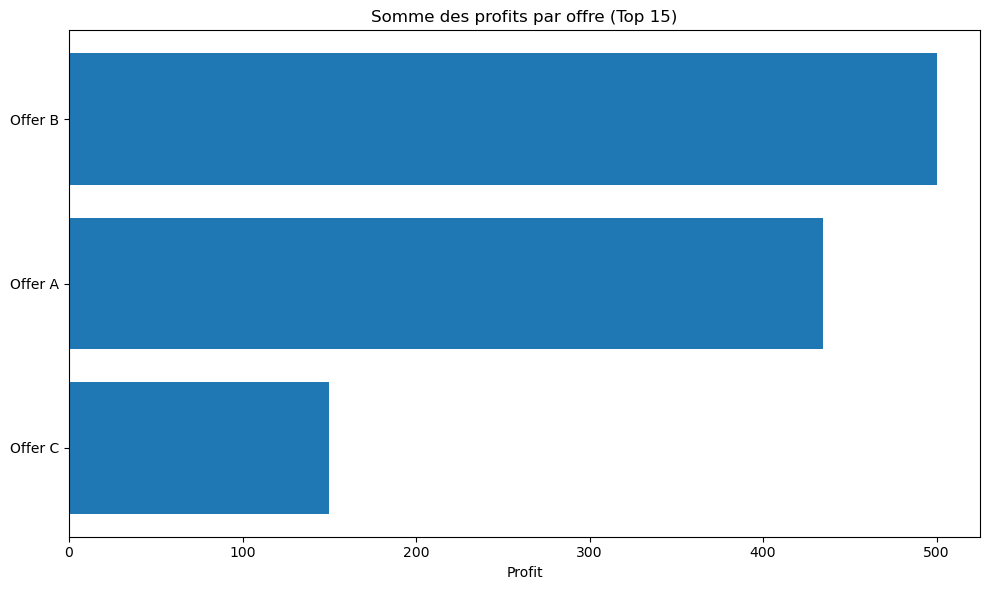

WindowsPath('out/profit_by_offer.png')

In [8]:
# 8a) Graphique ‚Äî Profits par Offre
plt.figure(figsize=(10, 6))
tmp = top_offers.sort_values("profit", ascending=True)
plt.barh(tmp["offer_name"].astype(str), tmp["profit"])
plt.title("Somme des profits par offre (Top 15)")
plt.xlabel("Profit")
plt.tight_layout()
png_path_offers = Path(OUT_DIR) / "profit_by_offer.png"
plt.savefig(png_path_offers)
plt.show()
png_path_offers

## 9-) Rapport Markdown
G√©n√®re un README de r√©sultats minimal dans le dossier out/ avec liens vers les PNG

In [9]:
# 9) Rapport Markdown

report_md = f"""# Rapport Everflow ‚Äî {FROM_DATE} ‚Üí {TO_DATE}

**Fuseau**: {EFLOW_TIMEZONE_ID} ‚Ä¢ **Devise**: {EFLOW_CURRENCY_ID}

## Profits par Offre
![profit_by_offer](profit_by_offer.png)

## Profits par Affili√©
![profit_by_affiliate](profit_by_affiliate.png)

## Profits par Advertiser
![profit_by_advertiser](profit_by_advertiser.png)

_G√©n√©r√© par le notebook ‚ÄúEverflow API Analytics ‚Äî Portfolio‚Äù_
"""

Path(OUT_DIR, "REPORT.md").write_text(report_md, encoding="utf-8")
Path(OUT_DIR, "REPORT.md")

WindowsPath('out/REPORT.md')

## 10-) Ex√©cution ‚Äúone-click‚Äù
Fonction utilitaire pour rejouer l‚Äôensemble en une ligne avec d‚Äôautres dates

In [10]:
# 10) Ex√©cution "one-click"

def run_pipeline(from_date: str, to_date: str, out_dir: str = "out", use_mock: bool = False):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    if use_mock:
        _rows = MOCK_ROWS
    else:
        _rows = fetch_aggregated_table(
            from_date=from_date,
            to_date=to_date,
            columns=["offer", "affiliate"],
            timezone_id=EFLOW_TIMEZONE_ID,
            currency_id=EFLOW_CURRENCY_ID
        )
    _df = rows_to_df(_rows)
    # Agr√©gations
    _offers = topn_profit_by(_df, "offer")
    _aff    = topn_profit_by(_df, "affiliate")
    _adv    = topn_profit_by(_df, "advertiser")

    # Graphiques (sauvegarde)
    def save_barh(df, value_col, label_col, title, path):
        plt.figure(figsize=(10,6))
        d = df.sort_values(value_col, ascending=True)
        plt.barh(d[label_col].astype(str), d[value_col])
        plt.title(title)
        plt.xlabel(value_col.capitalize())
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

    save_barh(_offers, "profit", "offer_name", "Somme des profits par offre (Top 15)", Path(out_dir)/"profit_by_offer.png")
    save_barh(_aff,    "profit", "affiliate_name", "Somme des profits par affili√© (Top 15)", Path(out_dir)/"profit_by_affiliate.png")
    save_barh(_adv,    "profit", "advertiser_name", "Somme des profits par advertiser (Top 15)", Path(out_dir)/"profit_by_advertiser.png")

    # Rapport
    rep = f"""# Rapport Everflow ‚Äî {from_date} ‚Üí {to_date}

**Fuseau**: {EFLOW_TIMEZONE_ID} ‚Ä¢ **Devise**: {EFLOW_CURRENCY_ID}

## Profits par Offre
![profit_by_offer](profit_by_offer.png)

## Profits par Affili√©
![profit_by_affiliate](profit_by_affiliate.png)

## Profits par Advertiser
![profit_by_advertiser](profit_by_advertiser.png)
"""
    Path(out_dir, "REPORT.md").write_text(rep, encoding="utf-8")
    return {"rows": len(_rows), "out": str(Path(out_dir).resolve())}

# Exemple:
run_pipeline(FROM_DATE, TO_DATE, OUT_DIR, use_mock=USE_MOCK)

{'rows': 3, 'out': 'C:\\Users\\ouldb\\Documents\\Everflow-API-Analytics\\out'}

# üèÅ Conclusion et R√©sultats

### üìà R√©sum√© de l‚Äôex√©cution
Le notebook **Everflow API Analytics** a permis de :
- r√©cup√©rer des statistiques agr√©g√©es de l‚ÄôAPI Everflow sur une p√©riode donn√©e
- calculer les indicateurs de performance principaux : **revenu, payout, profit, conversions, clics**
- g√©n√©rer automatiquement **trois graphiques cl√©s** :
  1. üìä Profit par **offre (Offer)**
  2. ü§ù Profit par **affili√© (Affiliate)**
  3. üè¢ Profit par **advertiser (Annonceur)**

Ces visuels permettent d‚Äôidentifier rapidement les acteurs les plus performants du r√©seau.

### üñºÔ∏è Visualisations g√©n√©r√©es
Les graphiques et le rapport final ont √©t√© enregistr√©s dans le dossier `out/` :
- `profit_by_offer.png`
- `profit_by_affiliate.png`
- `profit_by_advertiser.png`
- `REPORT.md`

Ci-dessous, un aper√ßu des r√©sultats :

![profit_by_offer](out/profit_by_offer.png)
![profit_by_affiliate](out/profit_by_affiliate.png)
![profit_by_advertiser](out/profit_by_advertiser.png)

### üß≠ Ce que d√©montre ce projet
‚úÖ Ma√Ætrise de l‚Äôint√©gration d‚Äôune **API REST analytique** (Everflow)  
‚úÖ Transformation de donn√©es brutes JSON en **indicateurs exploitables** avec Pandas  
‚úÖ Production de **visualisations automatiques** et d‚Äôun rapport r√©utilisable  
‚úÖ Capacit√© √† **structurer un projet complet** (authentification, logique m√©tier, visualisation, rapport)

> üí¨ *Ce projet illustre ma capacit√© √† concevoir des pipelines de donn√©es simples mais robustes, capables de transformer des donn√©es API en insights visuels clairs et pr√™ts √† √™tre partag√©s.*